# Overview

[Note: for any compatibility issues, I am running this notebook on python2.7]

As I try to learn as much as I can about data science by working with publicly available data sets and the examples of others, the question of which set of data to analyze, given their relative ubiquity on the web nowadays, presented itself rather obstinantly to me.

So I thought of the current situation I find myself in, living abroad in the eternal city, Rome. If someone asks me what I like most of Rome, I must give pause and think of its infinite beautiful facades. But if someone asks me what I like least, I can answer quite easily: traffic. Rather than complaining, as one is wont to do in (southern(ish)) Italy, I decided that perhaps I could use my nascent learned data science skills to see if I can't learn something useful about Rome's traffic catastrophe and find patterns that only statistical methods on large data sets can find.

Sure enough, even Rome has certain public data free for the public to play with. So I obtained data on traffic accidents and traffic incidences involving pedestrians from Rome's public data repo at

http://dati.comune.roma.it/download

(all data is in Italian, of course) and did the most basic of analyses.

First we'll have a look at the data involving pedestrians ('pedoni') as the data set is smaller. Next we will have a look at the general traffic incidences, of which there are many more case with a plethora of descriptive data attached to each incidence.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import json
import re
import textwrap
from unidecode import unidecode
from sklearn import cross_validation
import datetime
import geoplotlib
from sklearn.ensemble import RandomForestClassifier
import patsy
from sklearn.neighbors.kde import KernelDensity

# Pedoni data

Here I took a much smaller data set that only involved pedestrians (and some sort of vehicle). This set was not as extensive as the general traffic incidence set below, but allowed me to warm up on reading in the JSON data Rome provided and look at the distribution of incidences as a function of age and gender, and to see what percentage of (reported) incidences result in a pedestrian death.



First we simply write a function to read in the data and clean it up a little bit so that Pandas can successfully parse the data.

In [47]:
def load_pedoni_data(json_file):
    with open(json_file, 'r') as filename:
        data = filename.readlines()

    # Overwrite first line with just a [    
    data[0] = '[\n'
    data[-1] = ']\n'

    with open('edited_json_pedoni.json', 'w') as filename:
        filename.writelines(data)

    return(pd.read_json("edited_json_pedoni.json", orient='records'))

pedoni = load_pedoni_data('json_pedoni_01.7.2014_31.12.2014.json')
pedoni.columns.values

array([u'AANascita', u'Deceduto', u'DecedutoDopo', u'IDProtocollo',
       u'Sesso', u'TipoLesione', u'TipoPersona'], dtype=object)

I want to look at the incidences as a function of age, since they provide the birth year in the data. I get rid of birth years of '0' (nonsensical data) then create a new column that gives the age of the victim.

In [48]:
pedoni = pedoni.query('AANascita != 0')
pedoni['age'] = pedoni.apply(lambda row:2015-row['AANascita'], axis=1)

Now I'll plot the distribution of ages and gender in the incidences, comparing each distribution for incidences where the pedestrian survived versus where a fatality resulted (the 'Deceduto' feature indicates the victim died immediately as a result of the incident). We can also plot the number of incidences without fatalities versus those with.

Total number of cases with fatalities: 17


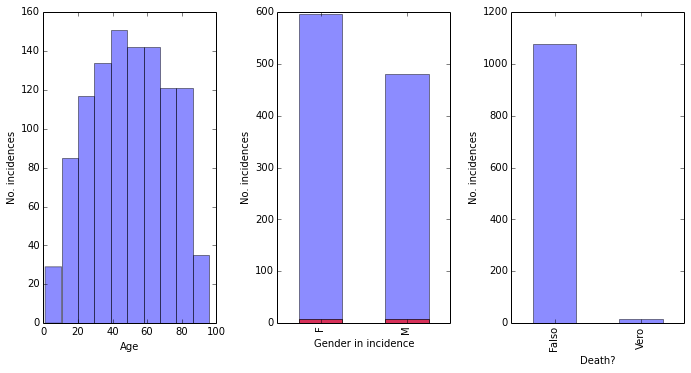

In [49]:
f, a = plt.subplots(1,3)
f.tight_layout()
f.set_size_inches(10,5)

width=0.35
index=np.arange(2)

a[0].hist(pedoni[pedoni.Deceduto == 'Falso'].age, color='b', alpha=0.45) # no fatality
# There is a problem with making a histogram of these data- perhaps not enough points
#a[0].hist(pedoni[pedoni.Deceduto == 'Vero'].age, color='r', alpha=0.65) # fatality
a[0].set_xlabel('Age')
a[0].set_ylabel('No. incidences')

plt.subplot2grid((1,3),(0,1))
pedoni[pedoni.Deceduto == 'Falso'].Sesso.value_counts().plot(kind='bar', color='b', alpha = 0.45) # no fatality
pedoni[pedoni.Deceduto == 'Vero'].Sesso.value_counts().plot(kind='bar', color='r', alpha = 0.65) # death resulted
plt.xlabel('Gender in incidence')
plt.ylabel('No. incidences')

plt.subplot2grid((1,3),(0,2))
pedoni.Deceduto.value_counts().plot(kind='bar', alpha = 0.45)
plt.xlabel('Death?')
plt.ylabel('No. incidences')

print('Total number of cases with fatalities: {0}'.format(len(pedoni[pedoni.Deceduto == 'Vero'])))

You can see in the distribution of the ages that the number of incidences with no fatalies far outweighs those with fatalities. So it isn't too useful to look at. However, in the traffic accidents below we can look at a more useful quantity- whether or not death *or* injury occurs, as this (macabre, yes) feature gives better statistics (and is still useful to look at).

# Incidenti data

We can proceed to analyze the traffic incident ('incidenti' in Italian) data, though we have to clean up the data a bit more thoroughly for processing, which needs to be done carefully, as the JSON files are much larger for these incidences (approximately 15K records for every 6 months of data). We examine one 6 month period in particular, July-December 2014 (the same period was used for the pedoni data above).

There are a few things we need to do first - in Python, so all processes are reproducible. The JSON file provided by the Roma public data utility has a few things we need to clear up- I remove the initial line with an unnecessary label of the file name and make sure brackets and commas are properly arranged so as to be read by pd.read_json. I also have to decode the text from 'latin' and then use a handy utility called 'unidecode' to reincode each record in the JSON file such that the accents (ubiquitous in Italian) are replaced with their nearest unaccented equivalent. 

I also remove one particular field, 'DaSpecificare' because it is a qualitative descriptive field (a short phrase describing the incident) that I don't expect to be of use in any analysis (it can't possibly be turned into a categorical variable) and because certain descriptions involved quotes in their descriptions (much like my current university isn't called La Sapienza, but rather Università di Roma, 'La Sapienza') that muck with the expected JSON format. So I just remove that field completely and write to a new file.

I also do a few other things that I have now lumped into this function "clean_incidenti_data", including replacing commas with decimals to match with the locale on my machine for converting to floats

In [2]:
# for now pd.read_json seems to get angry if I load to many lines in, so only load 9000 for now 
# (just to get an idea of what to do- reuse same code with data set)
def load_incidenti_data(json_file):
    with open(json_file, 'r') as filename:
        # for now pd.read_json seems to get angry if I load to many lines in, so only load 9000 for now 
        # (just to get an idea of what to do- reuse same code with data set)
        # (I really don't understand this error: 
        # ValueError: Key name of object must be 'string' when decoding 'object'
        # and the internet is not helping)
        data = [next(filename) for x in xrange(9000)]
        #data = filename.readlines()

    for num, line in enumerate(data,0):
        if num == 0:
            data[num] = '[\n'
        # must remove comma at end of last line
        elif num == len(data)-2 and len(data) > 2:
            # need to include a (mac?) symbol \r that comes with each new line
            tmp = re.sub("\"DaSpecificare.*?.\", ","",re.sub(",\r$","",line))
            # In the future I should look for a BOM to detect encoding automatically
            data[num] = unidecode(tmp.decode('latin'))
        elif num == len(data)-1:
            data[num] = ']\n'
        else:
            tmp = re.sub("\"DaSpecificare.*?.\", ","",line)
            data[num] = unidecode(tmp.decode('latin'))

    with open('edited_json_incidenti.json', 'w') as filename:
        filename.writelines(data)
    
    return(pd.read_json('edited_json_incidenti.json', orient='records'))

# We are overwriting the dataframe in each of the steps below, so we turn this warning off
pd.options.mode.chained_assignment = None  # default='warn'
def clean_incidenti_data(dataframe):
    dataframe['harmed'] = dataframe.apply(lambda row: row['NUM_MORTI']+row['NUM_FERITI'], axis=1)
    dataframe.drop(['NUM_MORTI','NUM_FERITI'], axis=1, inplace=True)

    # Drop terms that don't match the time format I want
    dataframe['time_match'] = dataframe.apply(lambda row: re.search(' \d{1,2}\.\d{2}',row['DataOraIncidente']) is not None, axis=1)
    dataframe = dataframe.query('time_match')

    # Gives the time (of day) as a time_struct 
    dataframe['time'] = dataframe.apply(lambda row: datetime.datetime.strptime(re.search(' \d{1,2}\.\d{2}\.\d{2}',row['DataOraIncidente']).group().lstrip(), '%H.%M.%S'), axis=1)
    dataframe.drop('time_match', inplace=True, axis=1)

    # Finally, convert European style decimals to US-style, since my locale is not European
    # A bit of a workaround, but it functions
    dataframe['Latitudine'] = dataframe.apply(lambda row: row['Latitudine'].replace(',','.'), axis=1)
    dataframe['Longitudine'] = dataframe.apply(lambda row: row['Longitudine'].replace(',','.'), axis=1)
    return(dataframe)

Now before doing anything else, we set aside 30% of the data, randomly chosen, as test data. We take what is leftover as training data and clean it (which amounts to renaming some rows and converting European style decimals to American style for greater ease of the use of float).

In [3]:
incidenti = load_incidenti_data('json_incidenti_01.7.2014_31.12.2014.json')

test = incidenti.sample(frac=0.3, replace=False)
train = incidenti.loc[~incidenti.index.isin(test.index)]
train = clean_incidenti_data(train)

train.columns.values

array([u'CONFERMATO', u'Chilometrica', u'CondizioneAtmosferica',
       u'DataOraIncidente', u'FondoStradale', u'Gruppo', u'ID',
       u'Illuminazione', u'Latitudine', u'Localizzazione1',
       u'Localizzazione2', u'Longitudine', u'NUM_ILLESI', u'NUM_RISERVATA',
       u'NaturaIncidente', u'ParticolaritaStrade', u'Pavimentazione',
       u'Segnaletica', u'Strada02', u'Strada1', u'Strada2', u'TipoStrada',
       u'Traffico', u'Visibilita', 'harmed', 'time'], dtype=object)

Let's look at distributions of events with people injured versus those without injury (or death). I've taken only the features that seem to have a reasonable number of categorical choices that might be used for fitting later.

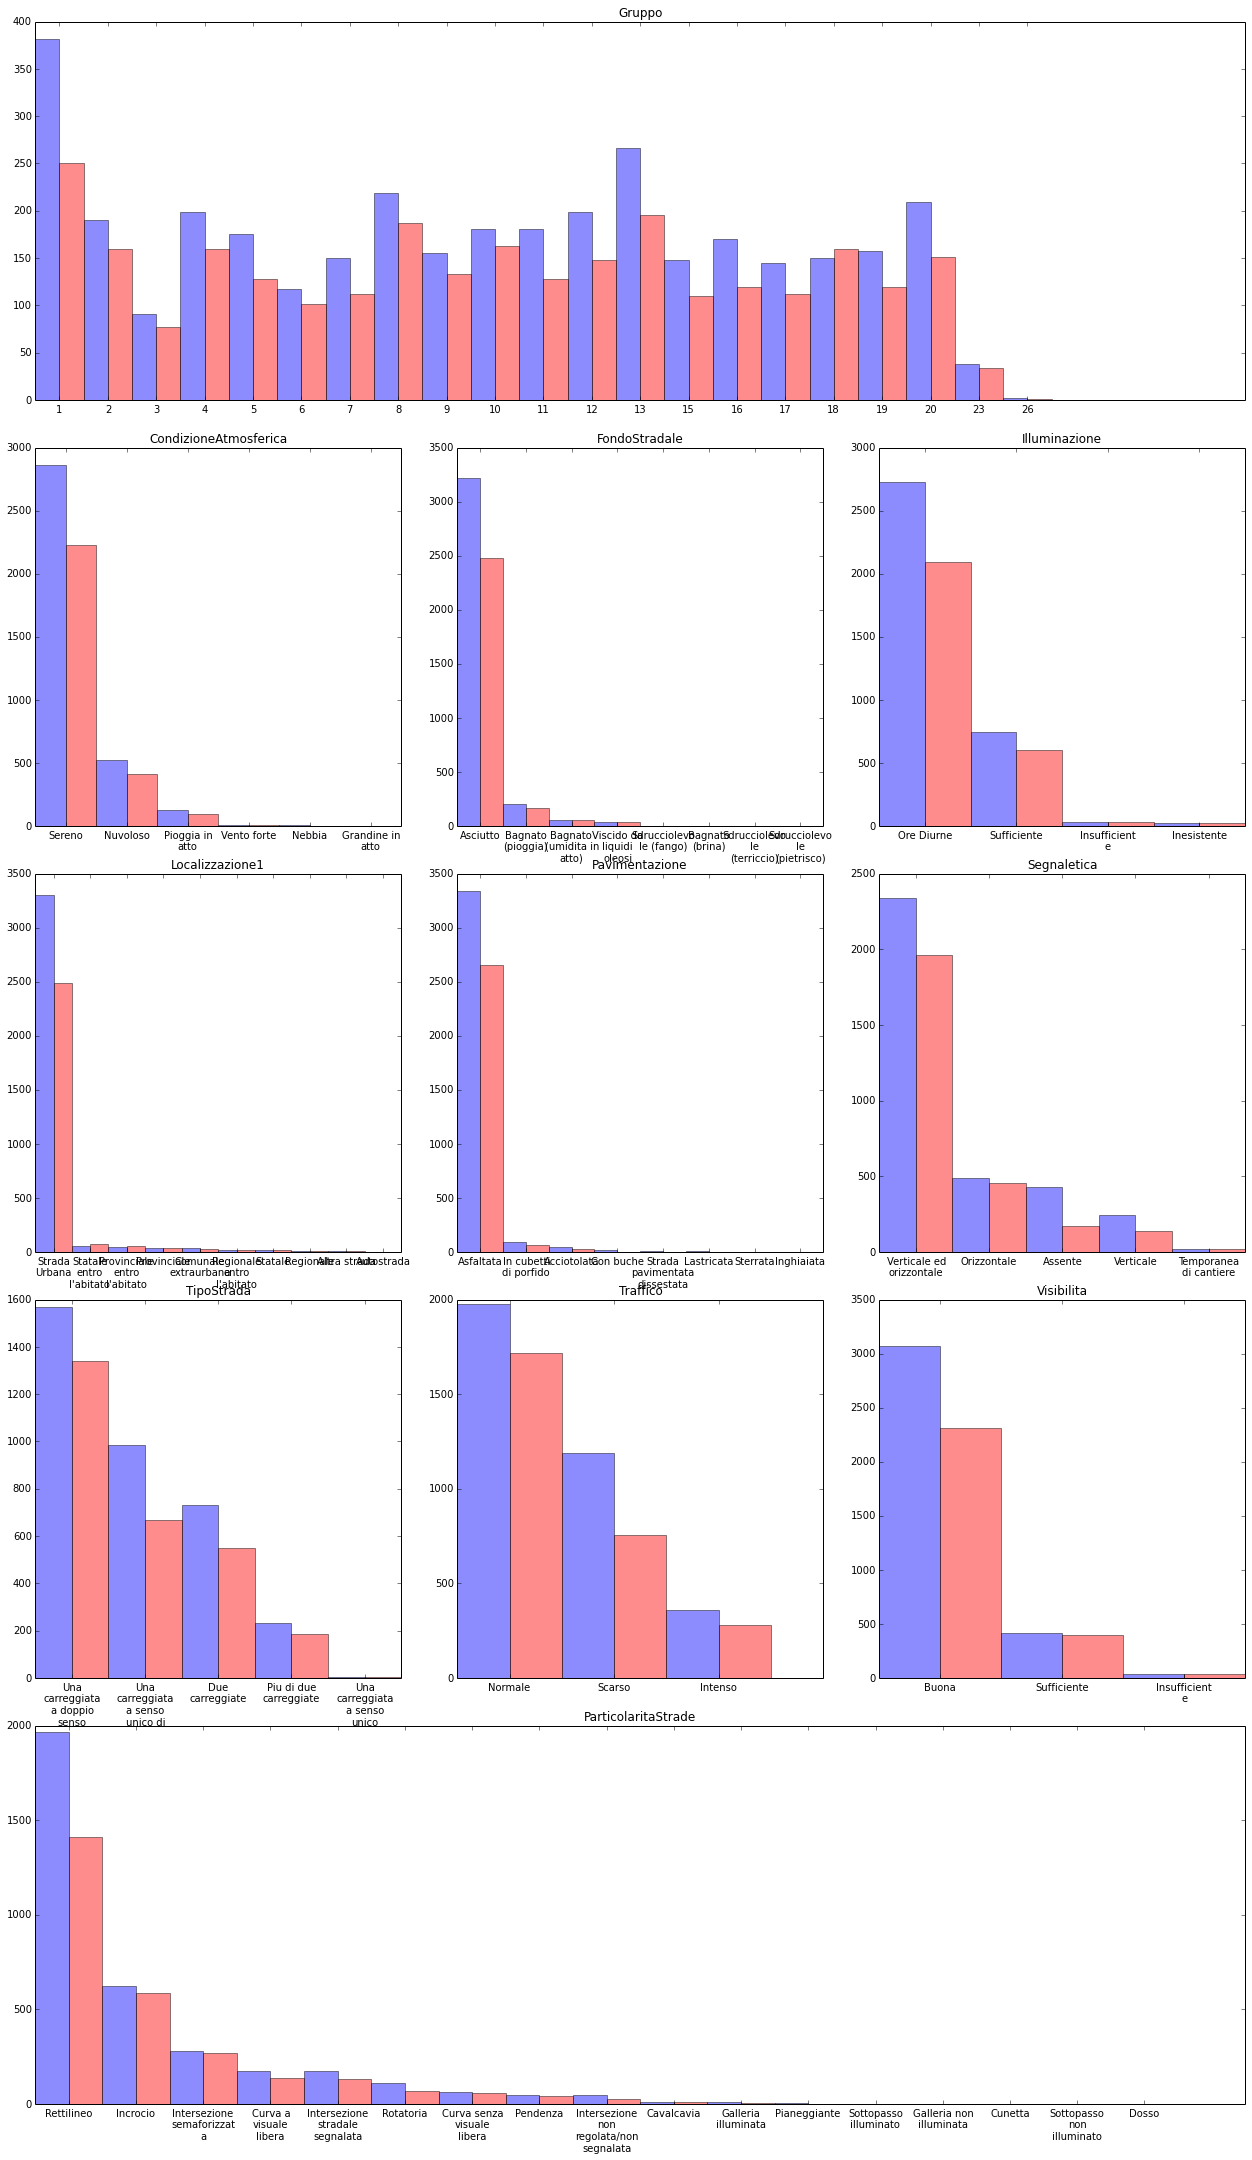

In [33]:
features=['CondizioneAtmosferica','FondoStradale','Illuminazione','Localizzazione1','Pavimentazione','Segnaletica','TipoStrada','Traffico','Visibilita']
fig = plt.figure(dpi=1600)
f, a = plt.subplots(len(features)/3+2,3,figsize=(18,30))
f.tight_layout(pad=3)

# One with a lot of options, don't exactly know what 'Group' is, but we can look at it as a variable
#Gruppo
plt.subplot2grid((len(features)/3+2,3),(0,0),colspan=3)
valsNoHarm = train[train.harmed == 0]['Gruppo'].value_counts().sort_index()
valsHarm = train[train.harmed > 0]['Gruppo'].value_counts().sort_index()
keys1 = valsNoHarm.keys()
keys2 = valsHarm.keys()
ind = np.arange(len(keys1))
ind2 = np.arange(len(keys2))
width=.5
plt.bar(ind,np.asarray(valsNoHarm),width, color='b', alpha=0.45)
plt.bar(ind2+width,np.asarray(valsHarm),width, color='r', alpha=0.45)
plt.xticks(ind+width,keys1)
plt.title('Gruppo')

for i,feature in enumerate(features,0):
    valsNoHarm = train[train.harmed == 0][feature].value_counts()
    valsHarm = train[train.harmed > 0][feature].value_counts()
    keys = valsNoHarm.keys()
    keys2 = valsHarm.keys()
    keys = [textwrap.fill(text,12) for text in keys]
    ind = np.arange(len(keys))
    ind2 = np.arange(len(keys2))
    width=.5
    a[i/3+1,i%3].bar(ind,np.asarray(valsNoHarm),width, color='b', alpha=0.45)
    a[i/3+1,i%3].bar(ind2+width,np.asarray(valsHarm),width, color='r', alpha=0.45)
    a[i/3+1,i%3].set_xticks(ind+width)
    a[i/3+1,i%3].set_xticklabels(keys)
    a[i/3+1,i%3].set_title(feature)

# One with a lot of options, span last row
#ParticolaritaStrade
plt.subplot2grid((len(features)/3+2,3),(4,0),colspan=3)
valsNoHarm = train[train.harmed == 0]['ParticolaritaStrade'].value_counts()
valsHarm = train[train.harmed > 0]['ParticolaritaStrade'].value_counts()
keys = valsNoHarm.keys()
keys2 = valsHarm.keys()
keys = [textwrap.fill(text,12) for text in keys]
ind = np.arange(len(keys))
ind2 = np.arange(len(keys2))
width=.5
plt.bar(ind,np.asarray(valsNoHarm),width, color='b', alpha=0.45)
plt.bar(ind2+width,np.asarray(valsHarm),width, color='r', alpha=0.45)
plt.xticks(ind+width,keys)
plt.title('ParticolaritaStrade')


# Will fix padding of plots later

There don't seem to be any obvious deviations of incidences with harm done to those involved versus those without. For now we move on since there is no smoking gun discriminant between the two data sets in these categorical data.


One thing to note is that one must be careful with looking at just the raw numbers in these distributions- all I was really looking for was shape discrimination between the 'signal' events (incidents that had injury) and 'background' events, to use particle physics parlance. The raw (not percentage) can also be used to clue me in on what features will actually be useful for a fit- for example, if only a few 'signal' events occur in a particular category of one of the features with virtually no 'background' events, this is not all that useful for building a model from, since a decision tree that might be trained to think "is in this category of this feature -> predict signal" will apply this criterion extremely rarely (the non-law of low statistics).

We will look at latitude, longitude, and time features separately (they more warrant scatters and a histogram, respecively). We actually cut off the plot here because most of it is empty space- there are some outlier accidents under jurisdiction of Rome that should be removed from the data from reasonable analysis of the city proper.



In the two left plots we zoom in towards the city center. Later we will put these on a map.

(12.45, 12.55)

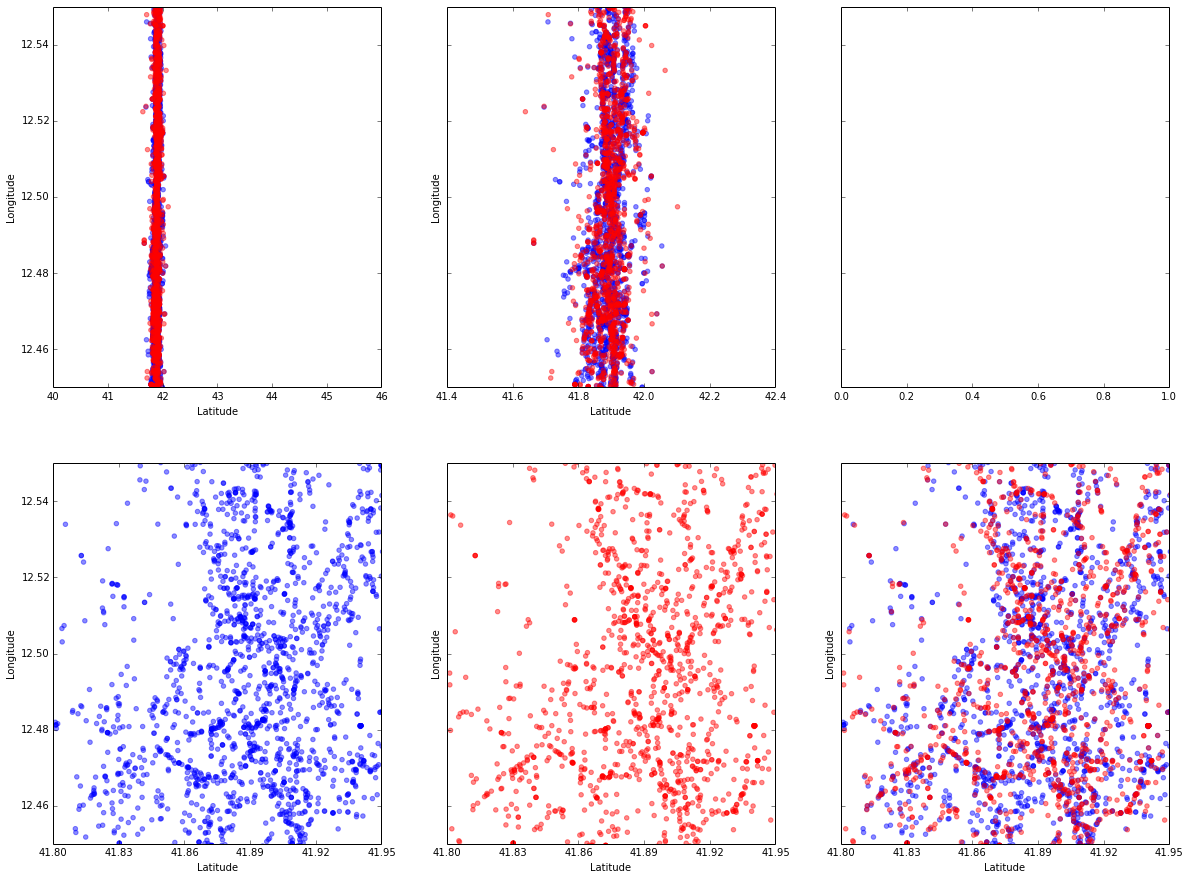

In [5]:
fig = plt.figure(figsize=(18,18), dpi=1600)
f, a = plt.subplots(2,3,sharey=True,figsize=(20,15))

# Effectively, this gives us a map of Rome with density of accidents
a[0,0].scatter(np.asarray(map(float,train.Latitudine[train.harmed == 0])),np.asarray(map(float,train.Longitudine[train.harmed == 0])), color='b', alpha = 0.45)
a[0,0].scatter(np.asarray(map(float,train.Latitudine[train.harmed > 0])),np.asarray(map(float,train.Longitudine[train.harmed > 0])), color='r', alpha = 0.45)
a[0,0].set_xlabel('Latitude')
a[0,0].set_ylabel('Longitude')

a[0,1].scatter(np.asarray(map(float,train.Latitudine[train.harmed == 0])),np.asarray(map(float,train.Longitudine[train.harmed == 0])), color='b', alpha = 0.45)
a[0,1].scatter(np.asarray(map(float,train.Latitudine[train.harmed > 0])),np.asarray(map(float,train.Longitudine[train.harmed > 0])), color='r', alpha = 0.45)
a[0,1].set_xlabel('Latitude')
a[0,1].set_xlim(41.4,42.4)
a[0,1].set_ylabel('Longitude')
a[0,1].set_ylim(12.2,12.8)

a[1,0].scatter(np.asarray(map(float,train.Latitudine[train.harmed == 0])),np.asarray(map(float,train.Longitudine[train.harmed == 0])), color='b', alpha = 0.45)
a[1,0].set_xlabel('Latitude')
a[1,0].set_xlim(41.8,41.95)
a[1,0].set_xticks(np.arange(41.8,41.95,.03))
a[1,0].set_ylabel('Longitude')
a[1,0].set_ylim(12.45,12.55)

a[1,1].scatter(np.asarray(map(float,train.Latitudine[train.harmed > 0])),np.asarray(map(float,train.Longitudine[train.harmed > 0])), color='r', alpha = 0.45)
a[1,1].set_xlabel('Latitude')
a[1,1].set_xlim(41.8,41.95)
a[1,1].set_xticks(np.arange(41.8,41.95,.03))
a[1,1].set_ylabel('Longitude')
a[1,1].set_ylim(12.45,12.55)

a[1,2].scatter(np.asarray(map(float,train.Latitudine[train.harmed == 0])),np.asarray(map(float,train.Longitudine[train.harmed == 0])), color='b', alpha = 0.45)
a[1,2].scatter(np.asarray(map(float,train.Latitudine[train.harmed > 0])),np.asarray(map(float,train.Longitudine[train.harmed > 0])), color='r', alpha = 0.45)
a[1,2].set_xlabel('Latitude')
a[1,2].set_xlim(41.8,41.95)
a[1,2].set_xticks(np.arange(41.8,41.95,.03))
a[1,2].set_ylabel('Longitude')
a[1,2].set_ylim(12.45,12.55)

In [31]:
# Let's also make a kde plot of latitude and longitude
from geoplotlib.utils import BoundingBox


# lats = np.asarray(map(float,train.Latitudine[train.harmed == 0]))
# longs = np.asarray(map(float,train.Longitudine[train.harmed == 0]))

# coords = train[['Latitudine','Longitudine']]
# coords.columns = ['lat','lon']
# data = geoplotlib.utils.DataAccessObject(coords)
# geoplotlib.dot(data)

data = geoplotlib.utils.read_csv('sample_geoplotlib_data.csv')

geoplotlib.dot(data)
#geoplotlib.set_bbox(BoundingBox.KBH)
geoplotlib.inline(500)
geoplotlib.show()

Traceback (most recent call last):
  File "/Library/Python/2.7/site-packages/geoplotlib/__init__.py", line 31, in _runapp
    app.start()
  File "/Library/Python/2.7/site-packages/geoplotlib/core.py", line 308, in start
    self.proj.fit(BoundingBox.from_bboxes([l.bbox() for l in self.geoplotlib_config.layers]))
  File "/Library/Python/2.7/site-packages/geoplotlib/layers.py", line 159, in bbox
    return BoundingBox.from_points(lons=self.data['lon'], lats=self.data['lat'])
  File "/Library/Python/2.7/site-packages/geoplotlib/utils.py", line 62, in __getitem__
    return self.dict[key]
KeyError: 'lon'


Let's learn to use geoplotlib while we are at it, and see what roads these clearly defined lines and arcs of accidents corrispond to

In [29]:
#nc = map(float,coords.loc[:,['lat','lon']])

coords.loc[:]

,lat,lon
1,41.92825,12.46112
2,41.86384,12.67445
3,41.74075,12.24047
5,41.90744,12.5651
9,41.86295,12.68899
10,41.90193,12.45873
11,41.8618,12.62762
15,41.96588,12.45186
17,41.94771,12.59625
18,41.81709,12.46239


We can also plot the incidences as a function of the time of day. Below we construct histograms for the two categories (no harm done in incident versus incidences with injury and/or death). 

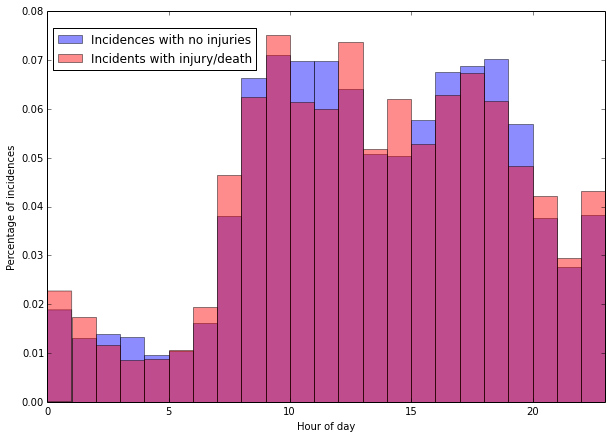

In [32]:
f, a = plt.subplots()
f.set_size_inches(10,7)
unharmed_bins = np.asarray(train[train.harmed == 0].time.groupby(train.time.dt.hour).count())
harmed_bins = np.asarray(train[train.harmed > 0].time.groupby(train.time.dt.hour).count())
ind = np.arange(24)
width = 1
noharmplt = a.hist(np.asarray(train[train.harmed == 0].time.dt.hour), bins=np.arange(24), normed=1, color='b', alpha=0.45)
harmplt = a.hist(np.asarray(train[train.harmed > 0].time.dt.hour), bins=np.arange(24), normed=1, color='r', alpha=0.45)
a.set_xlim(0,23)
a.set_xlabel('Hour of day')
a.set_ylabel('Percentage of incidences')
a.legend(('Incidences with no injuries','Incidents with injury/death'), loc=(.01,.85))


# a.bar(ind, unharmed_bins, width, color='b', alpha=0.45)
# a.bar(ind, harmed_bins, width, color='r', alpha=0.45)
# a.set_xticks(ind)
# a.set_xlim(0,24)
# a.set_xlabel('Hour of day')
# a.set_ylabel('No. of incidences')
# a.legend(loc='best')

So one 'cool' thing we can see here ('cool' in the sense of patterns that we are familiar with being manifest, not in the sense of injury or death ocurring) is the bimodal peak in incidences at rush hour- around 9-10 AM and 4-6 PM (it's Rome, with Italian work hours, OK?). Unfortunately for discriminating against the two data sets it seems incidences involving death or injury do not follow any particularly distinct pattern from those that do not.

However, it is interesting to note that the only places where the number of incidences that result in injuries outnumber those that do not, at least in this data set, are late at night, between either 10-11 PM or 1-2 AM.

Now at this point I was thinking that this data looked a bit like the [Titanic Kaggle competition](http://nbviewer.ipython.org/github/agconti/kaggle-titanic/blob/master/Titanic.ipynb) data I had seen a little while ago- in the sense that there were many categorical features predicting, rather morbidly yet again, the likelihood of death in that particular row of data (in that case representing a passenger on the Titanic). 



So I will try something naive here that emulates that strategy. This means a logistic regression and then a fit based upon the more complicated (but still ridiculously easy to call here) support vector machine (SVM) supervised learning. Actually, because so much of the data is categorical, plain old decision trees (and hence random forests) are probably a good bet. Let's try random forest first:

In [ ]:
# We still have to figure out how to include time (as a raw number of seconds, not in datetime struct)

# dmatrices is probably an intelligent way 
# to return a set of data that has had categorical data turned 
# into numbers suitable for RF

So maybe we can predict the likelihood of an accident occurring where I live when I typically walk home from work. I'll use some nearby coordinates and a time of about 19.30 of when I arrive home. We can try and compare this with...

In [34]:
?dmatrices

Object `dmatrices` not found.
